### Data Preperation

In [ ]:
## from matplotlib.ticker import FuncFormatter
import pandas as pd
import json
import matplotlib.pyplot as plt
## import matplotlib.dates as mdates
from datetime import datetime,timedelta
## import re
import os

In [ ]:
trips = pd.read_csv(r'C:\Users\Aviya\Downloads\Aviya Ohayon-20251203T133736Z-1-001\Aviya Ohayon\Clean Data\2024-02_Assign to parkinglot_Final_Status.csv')
weather = pd.read_csv(r'C:\Users\Aviya\Downloads\Aviya Ohayon-20251203T133736Z-1-001\Aviya Ohayon\Clean Data\2024-02_Final_Weather.csv')

In [116]:
# Work on trips only
trips = trips.copy()

trips["start_time"] = pd.to_datetime(trips["start_time"], errors="coerce")
trips["datetime_hour"] = trips["start_time"].dt.floor("H")

# count only trip_start if exists
if "event_types" in trips.columns and (trips["event_types"] == "trip_start").any():
    trips_for_count = trips[trips["event_types"] == "trip_start"].copy()
else:
    trips_for_count = trips.copy()

trips_hourly = (trips_for_count.groupby("datetime_hour")
                .size()
                .reset_index(name="trips_per_hour")
                .sort_values("datetime_hour")
                .reset_index(drop=True))

C:\Users\Aviya\AppData\Local\Temp\ipykernel_11404\1686805825.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  trips["datetime_hour"] = trips["start_time"].dt.floor("H")


In [117]:
# Work on weather only
weather = weather.copy()

weather["datetime"] = pd.to_datetime(weather["datetime"], errors="coerce")
weather["datetime_hour"] = weather["datetime"].dt.floor("H")

weather_cols = [
    "datetime_hour",
    "temp_c", "temp_max_c", "temp_min_c",
    "wind_direction_deg", "wind_speed_ms", "rain_mm"
]
weather_cols = [c for c in weather_cols if c in weather.columns]

weather_hourly = weather[weather_cols].copy()

# Final working dataset (hourly)
trips_weather = trips_hourly.merge(weather_hourly, on="datetime_hour", how="left")
trips_weather = trips_weather.sort_values("datetime_hour").reset_index(drop=True)

C:\Users\Aviya\AppData\Local\Temp\ipykernel_11404\2013887622.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  weather["datetime_hour"] = weather["datetime"].dt.floor("H")


In [118]:
trips_weather["hour"] = trips_weather["datetime_hour"].dt.hour

# Week starts Sunday: Sun=0, Mon=1, ... Sat=6
trips_weather["weekday"] = (trips_weather["datetime_hour"].dt.weekday + 1) % 7
weekday_map = {0:"Sun", 1:"Mon", 2:"Tue", 3:"Wed", 4:"Thu", 5:"Fri", 6:"Sat"}
trips_weather["weekday_name"] = trips_weather["weekday"].map(weekday_map)

# Weekend in Israel usually Fri+Sat
trips_weather["is_weekend"] = trips_weather["weekday"].isin([5, 6]).astype(int)
trips_weather["day_type"] = trips_weather["is_weekend"].map({1: "Weekend", 0: "Weekday"})

def tod_segment(h):
    if 0 <= h < 6: return "Night(0-6)"
    if 6 <= h < 12: return "Morning(6-12)"
    if 12 <= h < 18: return "Afternoon(12-18)"
    return "Evening(18-24)"

trips_weather["tod_segment"] = trips_weather["hour"].apply(tod_segment)

trips_weather[["datetime_hour","trips_per_hour","hour","weekday_name","day_type","tod_segment"]].head()


,datetime_hour,trips_per_hour,hour,weekday_name,day_type,tod_segment
0,2024-02-01 00:00:00,2,0,Thu,Weekday,Night(0-6)
1,2024-02-01 00:00:00,2,0,Thu,Weekday,Night(0-6)
2,2024-02-01 01:00:00,1,1,Thu,Weekday,Night(0-6)
3,2024-02-01 01:00:00,1,1,Thu,Weekday,Night(0-6)
4,2024-02-01 06:00:00,1,6,Thu,Weekday,Morning(6-12)


### Generic Functions

In [119]:
# Tables: continuous / categorical

def describe_continuous(series: pd.Series, name: str = None) -> pd.DataFrame:
    s = series.dropna()
    if name is None:
        name = series.name

    desc = s.describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]).to_frame(name)
    desc.loc["missing_rate"] = 1 - (len(s) / len(series)) if len(series) else np.nan
    desc.loc["n"] = len(s)
    return desc


def describe_categorical(series: pd.Series, name: str = None) -> pd.DataFrame:
    if name is None:
        name = series.name

    counts = series.value_counts(dropna=False)
    perc = series.value_counts(dropna=False, normalize=True) * 100
    out = pd.DataFrame({"count": counts, "percent": perc.round(2)})
    out.index.name = name
    return out


In [120]:
# Plots: histogram / box / ECDF

def plot_hist(series: pd.Series, title: str, xlabel: str, bins: int = 40):
    s = series.dropna()
    plt.figure()
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_box(series: pd.Series, title: str, ylabel: str):
    s = series.dropna()
    plt.figure()
    plt.boxplot(s, vert=True)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_ecdf(series: pd.Series, title: str, xlabel: str):
    s = series.dropna().sort_values()
    n = len(s)
    if n == 0:
        print("No data to plot.")
        return
    y = np.arange(1, n + 1) / n

    plt.figure()
    plt.step(s, y, where="post")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("ECDF")
    plt.grid(True, alpha=0.3)
    plt.show()


In [121]:
# Categorical plots + time plots

def plot_category_distribution(df, cat_col, title):
    tab = df[cat_col].value_counts(dropna=False)
    plt.figure()
    plt.bar(tab.index.astype(str), tab.values)
    plt.title(title)
    plt.xlabel(cat_col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()


def plot_mean_by_category(df, y_col, cat_col, title):
    g = df.groupby(cat_col)[y_col].mean().sort_values(ascending=False)
    plt.figure()
    plt.bar(g.index.astype(str), g.values)
    plt.title(title)
    plt.xlabel(cat_col)
    plt.ylabel(f"Mean {y_col}")
    plt.xticks(rotation=45, ha="right")
    plt.grid(True, axis="y", alpha=0.3)
    plt.show()


def plot_ecdf_by_group(df, x_col, group_col, title):
    plt.figure()
    for grp, dfg in df[[x_col, group_col]].dropna().groupby(group_col):
        s = dfg[x_col].sort_values()
        n = len(s)
        if n == 0:
            continue
        y = np.arange(1, n + 1) / n
        plt.step(s, y, where="post", label=str(grp))
    plt.title(title)
    plt.xlabel(x_col)
    plt.ylabel("ECDF")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def plot_hourly_profile(df, y_col, title):
    g = df.groupby("hour")[y_col].mean()
    plt.figure()
    plt.plot(g.index, g.values)
    plt.title(title)
    plt.xlabel("hour")
    plt.ylabel(f"Mean {y_col}")
    plt.grid(True, alpha=0.3)
    plt.show()


def plot_hourly_profile_by_group(df, y_col, group_col, title):
    plt.figure()
    for grp, dfg in df.groupby(group_col):
        g = dfg.groupby("hour")[y_col].mean()
        plt.plot(g.index, g.values, label=str(grp))
    plt.title(title)
    plt.xlabel("hour")
    plt.ylabel(f"Mean {y_col}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()


def plot_heatmap_weekday_hour(df, y_col, title):
    pivot = df.pivot_table(index="weekday_name", columns="hour", values=y_col, aggfunc="mean")
    order = ["Sun","Mon","Tue","Wed","Thu","Fri","Sat"]
    pivot = pivot.reindex([d for d in order if d in pivot.index])

    plt.figure()
    plt.imshow(pivot.values, aspect="auto")
    plt.title(title)
    plt.xlabel("hour")
    plt.ylabel("weekday_name")
    plt.xticks(ticks=np.arange(len(pivot.columns)), labels=pivot.columns)
    plt.yticks(ticks=np.arange(len(pivot.index)), labels=pivot.index)
    plt.colorbar(label=f"Mean {y_col}")
    plt.show()

### Trips in General

,metric,value
0,total_trips,5842.000000
1,mean_trips_per_hour,5.553232
2,median_trips_per_hour,4.000000
3,percent_hours_zero_trips,0.000000


,trips_per_hour
count,1052.000000
mean,5.553232
std,4.752286
min,1.000000
5%,1.000000
10%,1.000000
25%,2.000000
50%,4.000000
75%,8.000000
90%,13.000000


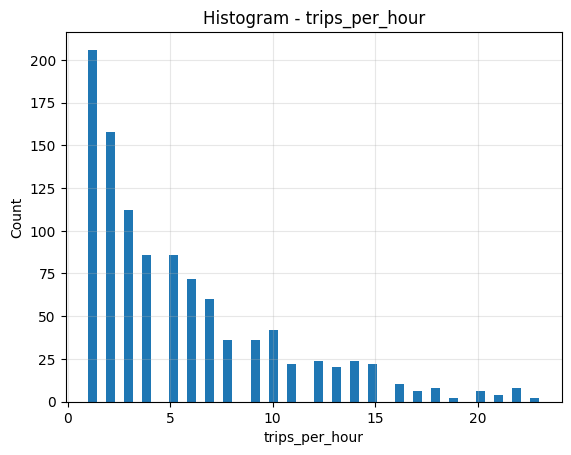

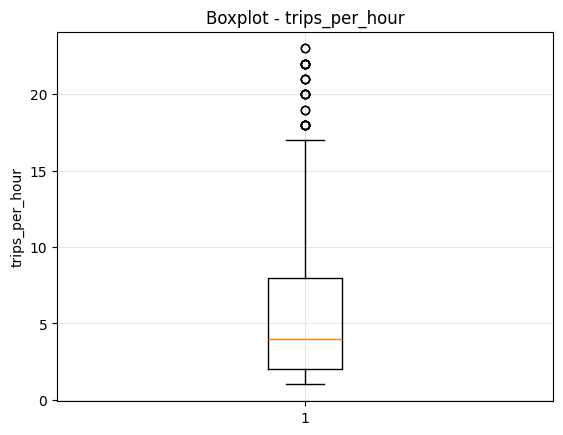

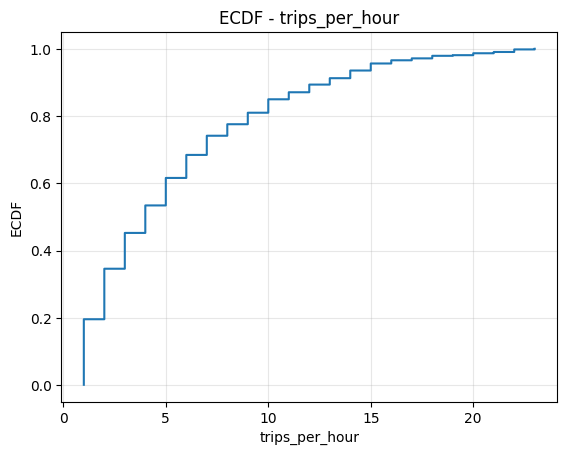

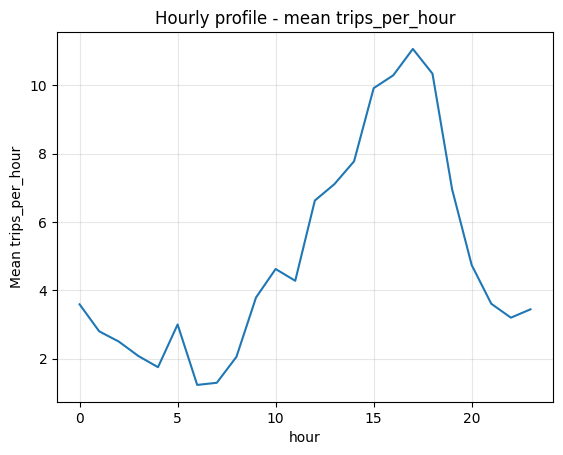

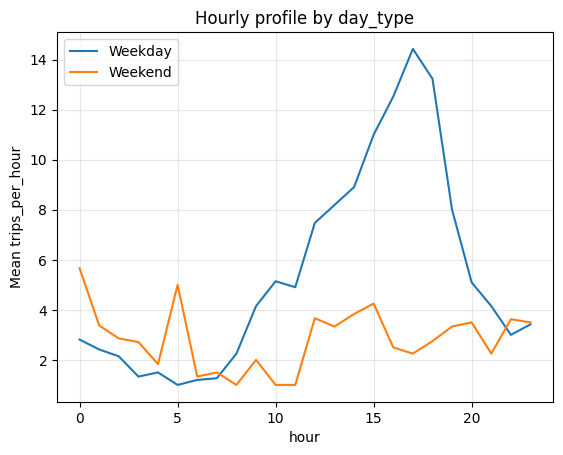

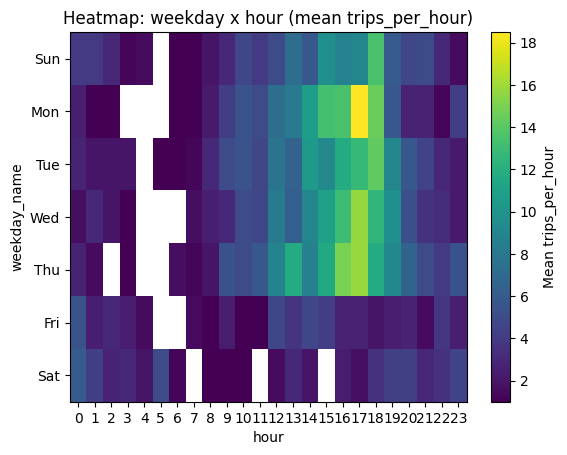

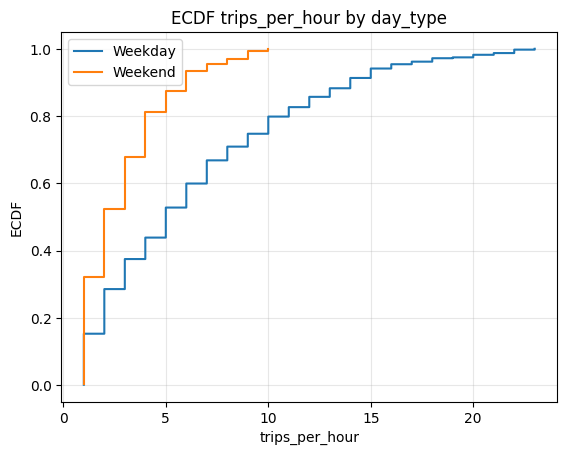

In [122]:
df = trips_weather  # short alias only for convenience inside this notebook

total_trips = df["trips_per_hour"].sum()
mean_trips = df["trips_per_hour"].mean()
median_trips = df["trips_per_hour"].median()
pct_zero = (df["trips_per_hour"] == 0).mean() * 100

summary_total_trips = pd.DataFrame({
    "metric": ["total_trips", "mean_trips_per_hour", "median_trips_per_hour", "percent_hours_zero_trips"],
    "value": [total_trips, mean_trips, median_trips, round(pct_zero, 2)]
})
display(summary_total_trips)

display(describe_continuous(df["trips_per_hour"], "trips_per_hour"))
plot_hist(df["trips_per_hour"], "Histogram - trips_per_hour", "trips_per_hour", bins=50)
plot_box(df["trips_per_hour"], "Boxplot - trips_per_hour", "trips_per_hour")
plot_ecdf(df["trips_per_hour"], "ECDF - trips_per_hour", "trips_per_hour")

plot_hourly_profile(df, "trips_per_hour", "Hourly profile - mean trips_per_hour")
plot_hourly_profile_by_group(df, "trips_per_hour", "day_type", "Hourly profile by day_type")
plot_heatmap_weekday_hour(df, "trips_per_hour", "Heatmap: weekday x hour (mean trips_per_hour)")
plot_ecdf_by_group(df, "trips_per_hour", "day_type", "ECDF trips_per_hour by day_type")


### Temperature

,temp_c
count,1052.000000
mean,16.361534
std,2.786407
min,9.266667
5%,11.633333
10%,12.600000
25%,14.333333
50%,16.800000
75%,18.141667
90%,19.600000


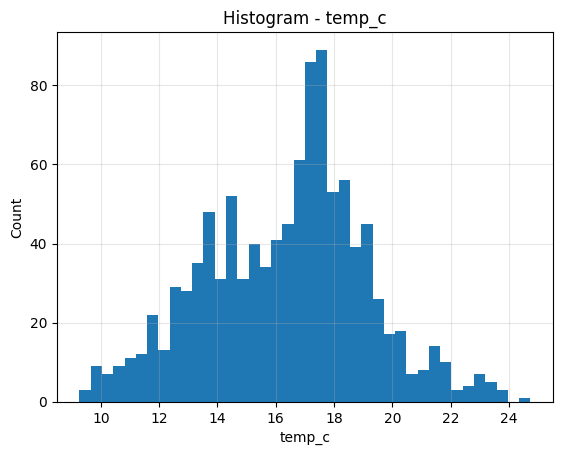

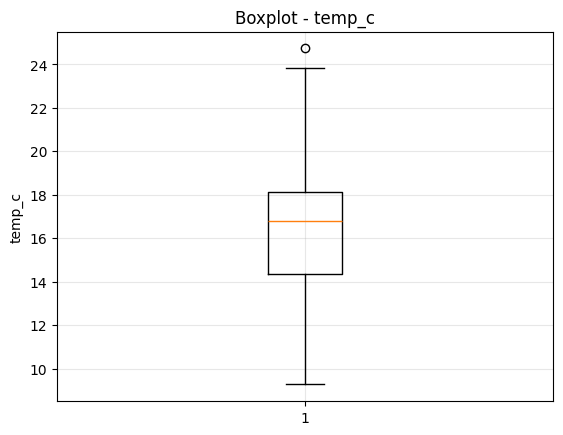

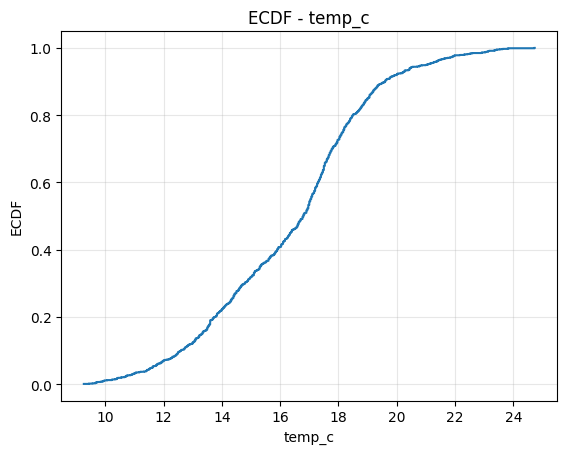

In [123]:
var = "temp_c"
display(describe_continuous(trips_weather[var], var))
plot_hist(trips_weather[var], f"Histogram - {var}", var, bins=40)
plot_box(trips_weather[var], f"Boxplot - {var}", var)
plot_ecdf(trips_weather[var], f"ECDF - {var}", var)


### temp_max_c

,temp_max_c
count,1052.000000
mean,16.654753
std,2.829010
min,9.600000
5%,11.855000
10%,12.800000
25%,14.600000
50%,17.100000
75%,18.400000
90%,20.000000


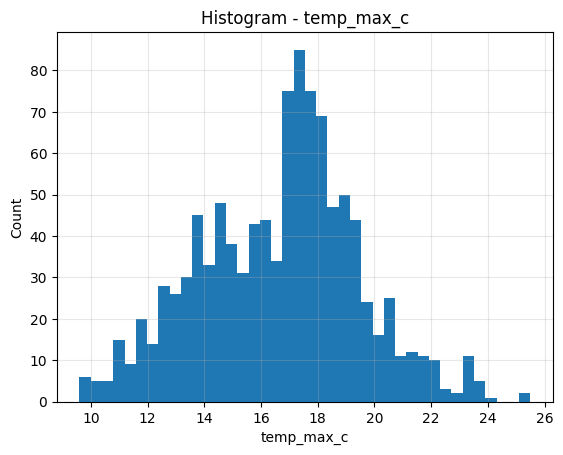

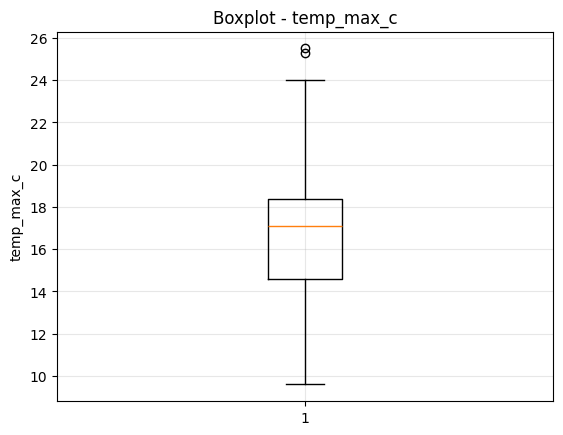

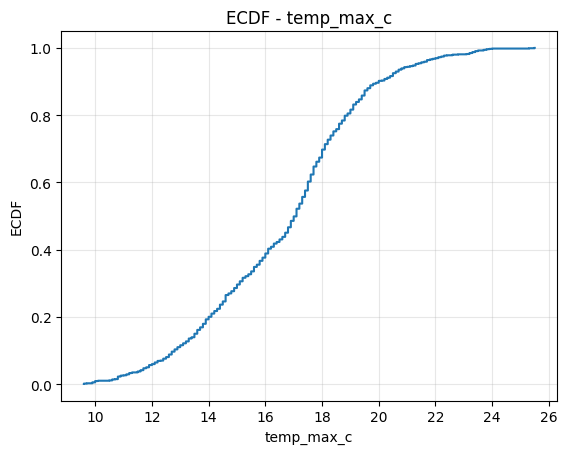

In [124]:
var = "temp_max_c"
display(describe_continuous(trips_weather[var], var))
plot_hist(trips_weather[var], f"Histogram - {var}", var, bins=40)
plot_box(trips_weather[var], f"Boxplot - {var}", var)
plot_ecdf(trips_weather[var], f"ECDF - {var}", var)


### temp_min_c

,temp_min_c
count,1052.000000
mean,16.085932
std,2.759789
min,8.900000
5%,11.500000
10%,12.500000
25%,14.000000
50%,16.550000
75%,17.900000
90%,19.100000


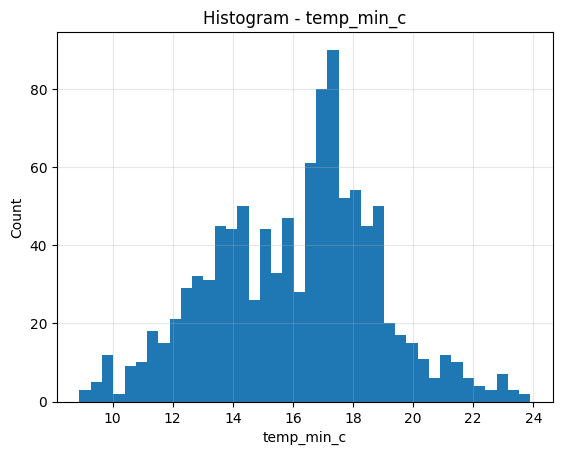

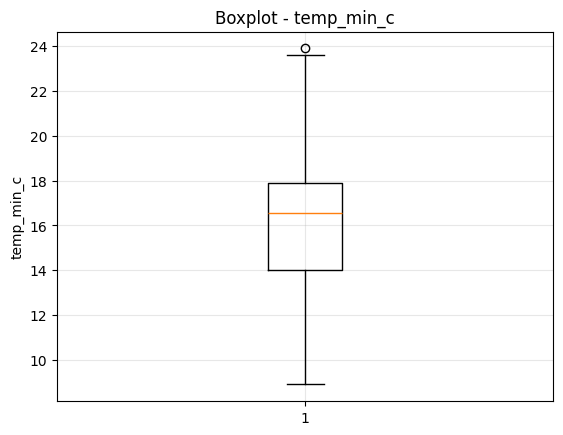

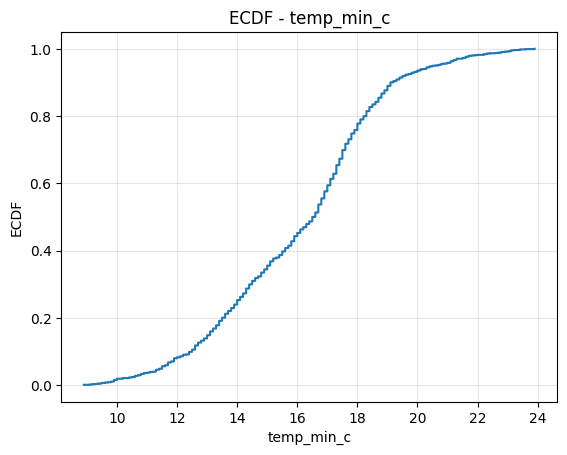

In [125]:
var = "temp_min_c"
display(describe_continuous(trips_weather[var], var))
plot_hist(trips_weather[var], f"Histogram - {var}", var, bins=40)
plot_box(trips_weather[var], f"Boxplot - {var}", var)
plot_ecdf(trips_weather[var], f"ECDF - {var}", var)


### wind_speed_ms

,wind_speed_ms
count,1052.000000
mean,3.132826
std,1.624385
min,0.300000
5%,1.033333
10%,1.400000
25%,2.033333
50%,2.816667
75%,3.833333
90%,5.330000


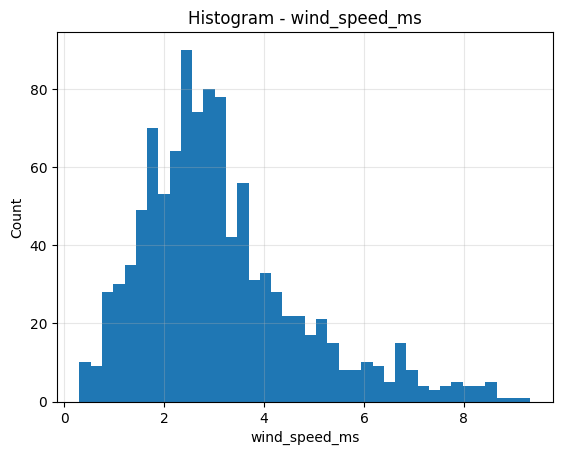

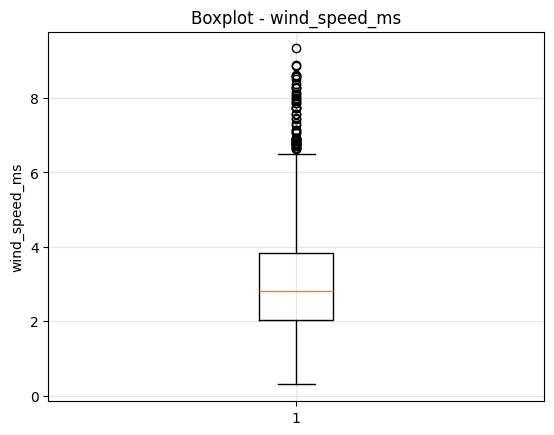

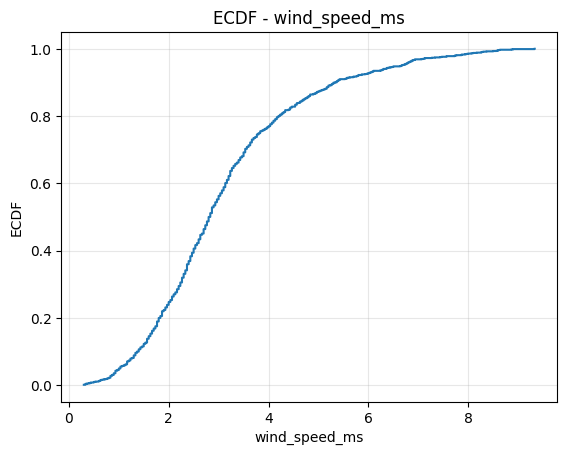

In [126]:
var = "wind_speed_ms"
display(describe_continuous(trips_weather[var], var))
plot_hist(trips_weather[var], f"Histogram - {var}", var, bins=40)
plot_box(trips_weather[var], f"Boxplot - {var}", var)
plot_ecdf(trips_weather[var], f"ECDF - {var}", var)

### rain_mm

,rain_mm
count,1052.000000
mean,0.084221
std,0.628682
min,0.000000
5%,0.000000
10%,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
90%,0.000000


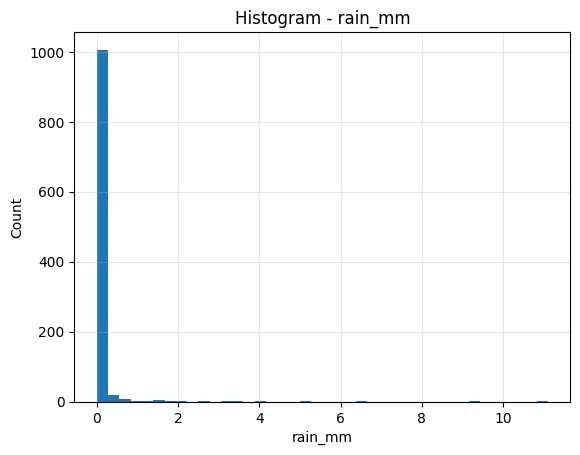

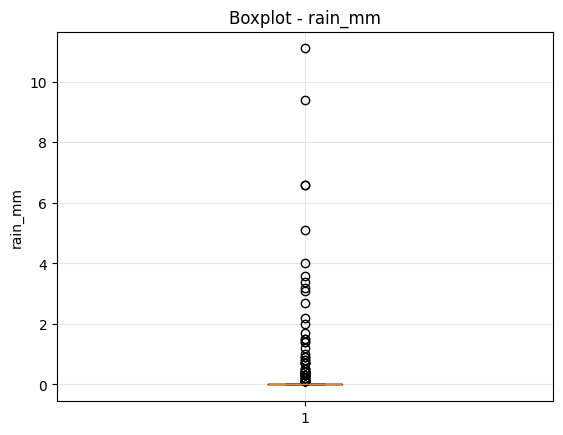

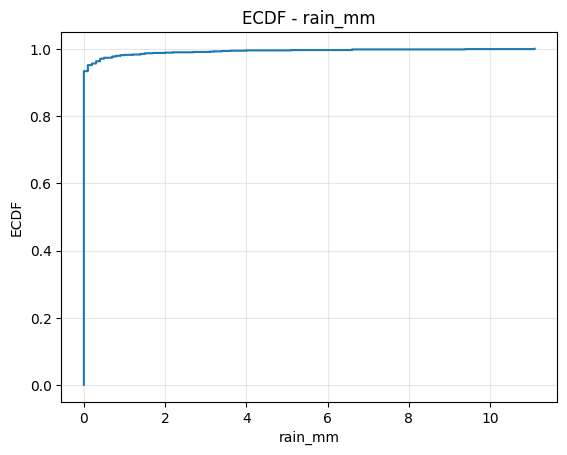

In [127]:
var = "rain_mm"
display(describe_continuous(trips_weather[var], var))
plot_hist(trips_weather[var], f"Histogram - {var}", var, bins=40)
plot_box(trips_weather[var], f"Boxplot - {var}", var)
plot_ecdf(trips_weather[var], f"ECDF - {var}", var)

### day_type

,count,percent
day_type,,
Weekday,784,74.52
Weekend,268,25.48


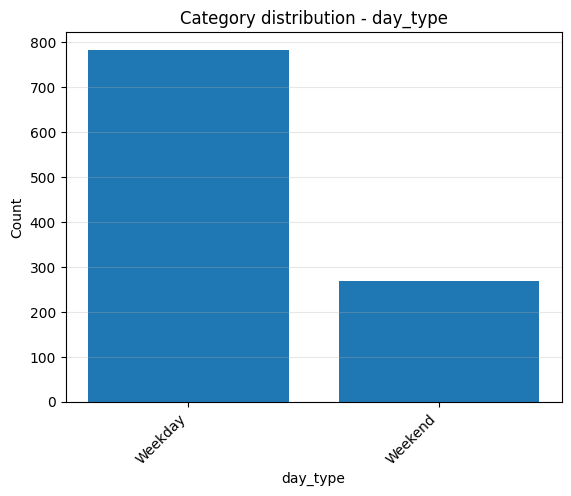

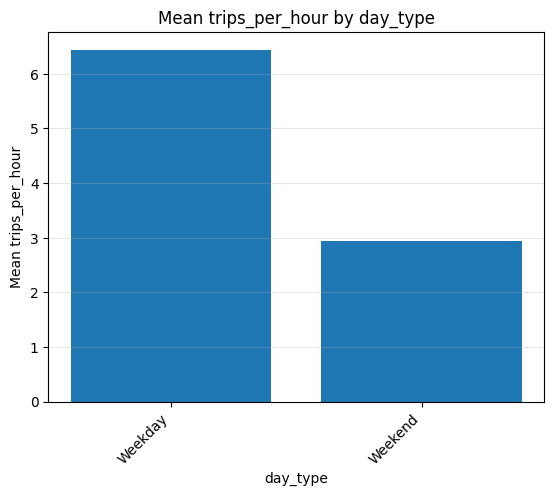

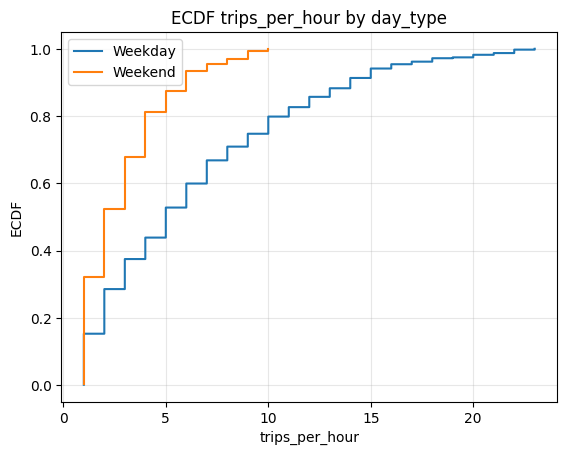

In [128]:
var = "day_type"
display(describe_categorical(trips_weather[var], var))
plot_category_distribution(trips_weather, var, f"Category distribution - {var}")
plot_mean_by_category(trips_weather, "trips_per_hour", var, f"Mean trips_per_hour by {var}")
plot_ecdf_by_group(trips_weather, "trips_per_hour", var, f"ECDF trips_per_hour by {var}")

### weekday_name

,count,percent
weekday_name,,
Thu,184,17.49
Sun,156,14.83
Tue,150,14.26
Wed,150,14.26
Fri,146,13.88
Mon,144,13.69
Sat,122,11.60


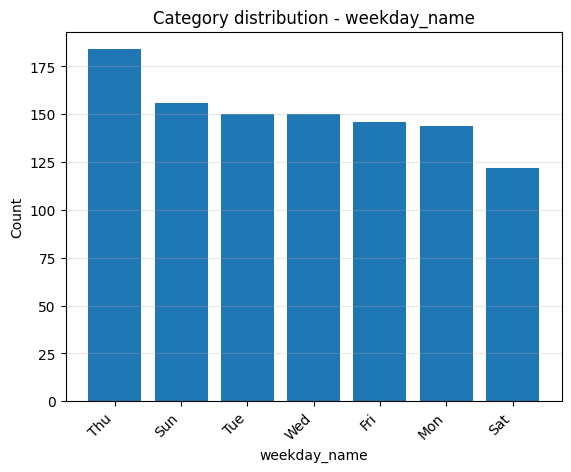

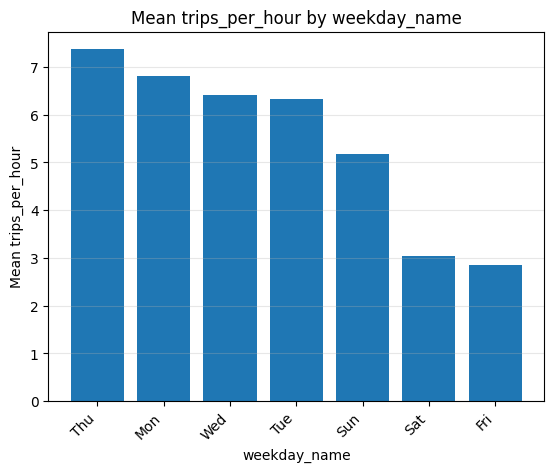

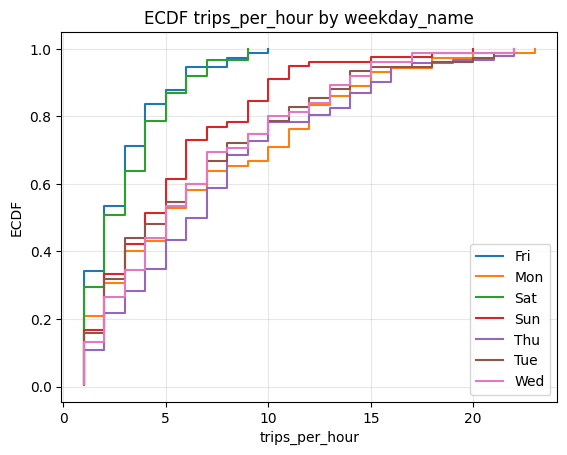

In [129]:
var = "weekday_name"
display(describe_categorical(trips_weather[var], var))
plot_category_distribution(trips_weather, var, f"Category distribution - {var}")
plot_mean_by_category(trips_weather, "trips_per_hour", var, f"Mean trips_per_hour by {var}")
plot_ecdf_by_group(trips_weather, "trips_per_hour", var, f"ECDF trips_per_hour by {var}")

### hour

,count,percent
hour,,
18,58,5.51
17,58,5.51
21,56,5.32
12,54,5.13
13,54,5.13
14,54,5.13
16,54,5.13
23,54,5.13
19,54,5.13


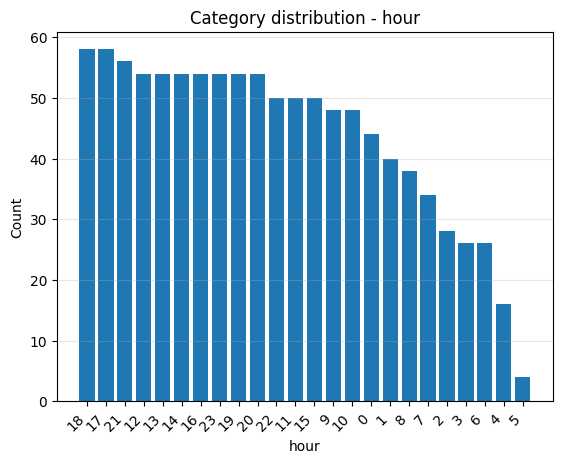

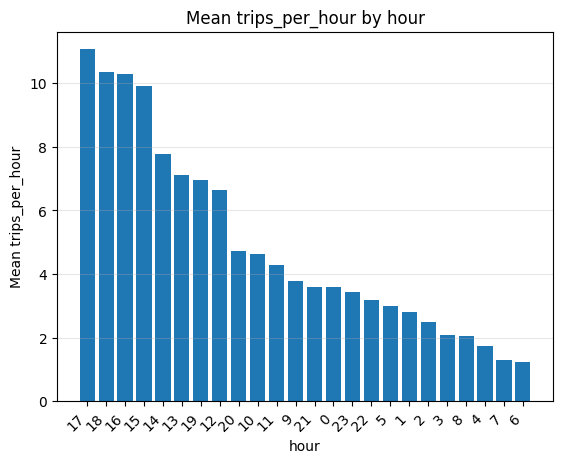

In [130]:
var = "hour"
display(describe_categorical(trips_weather[var], var))
plot_category_distribution(trips_weather, var, f"Category distribution - {var}")
plot_mean_by_category(trips_weather, "trips_per_hour", var, f"Mean trips_per_hour by {var}")

In [145]:
var = "hour"

# count per hour
counts = trips_weather[var].value_counts(dropna=False)

# build a full index of 0..23
hours_index = pd.Index(range(24), name="hour")

# align counts to 0..23, fill missing hours with 0
counts_full = counts.reindex(hours_index, fill_value=0)

# percent out of all non-missing hour values (or all rows if you prefer)
denom = trips_weather[var].notna().sum()
percent_full = (counts_full / denom * 100).round(2) if denom > 0 else counts_full * 0

hour_table = pd.DataFrame({
    "count": counts_full,
    "percent": percent_full
})

display(hour_table)


,count,percent
hour,,
0,44,4.18
1,40,3.80
2,28,2.66
3,26,2.47
4,16,1.52
5,4,0.38
6,26,2.47
7,34,3.23
8,38,3.61


### tod_segment

,count,percent
tod_segment,,
Evening(18-24),326,30.99
Afternoon(12-18),324,30.80
Morning(6-12),244,23.19
Night(0-6),158,15.02


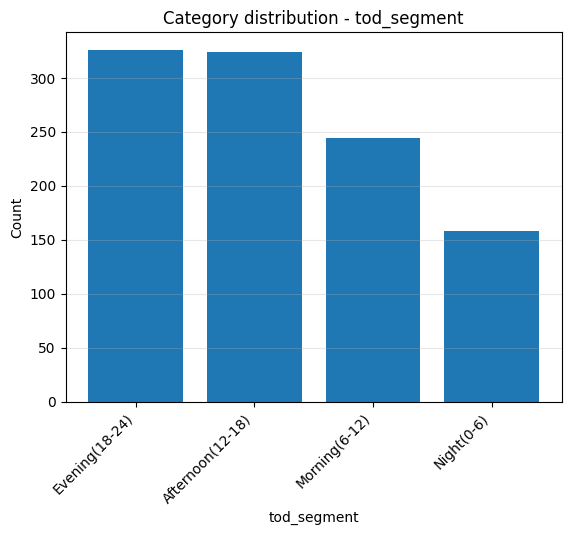

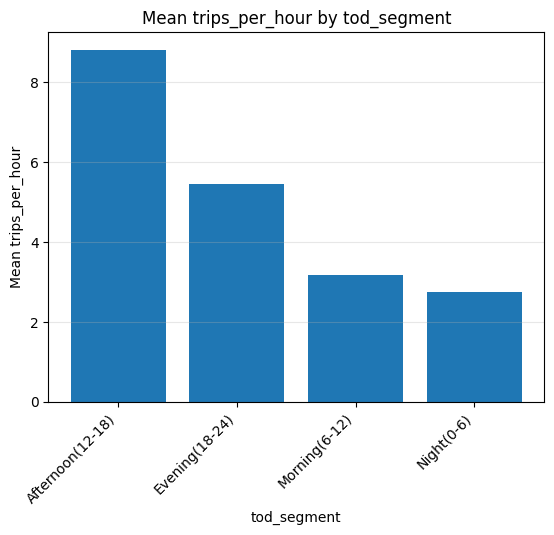

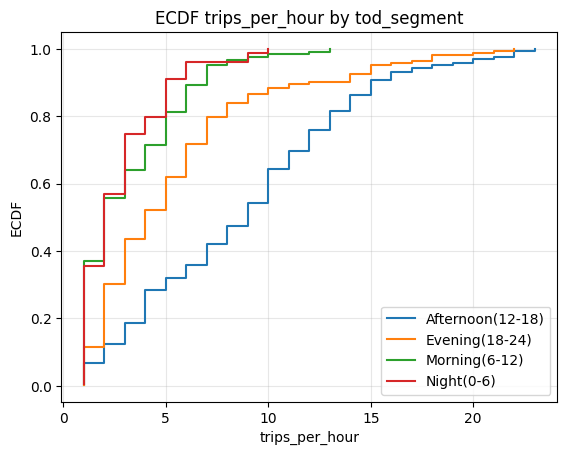

In [131]:
var = "tod_segment"
display(describe_categorical(trips_weather[var], var))
plot_category_distribution(trips_weather, var, f"Category distribution - {var}")
plot_mean_by_category(trips_weather, "trips_per_hour", var, f"Mean trips_per_hour by {var}")
plot_ecdf_by_group(trips_weather, "trips_per_hour", var, f"ECDF trips_per_hour by {var}")

### is_weekend

,count,percent
is_weekend,,
0,784,74.52
1,268,25.48


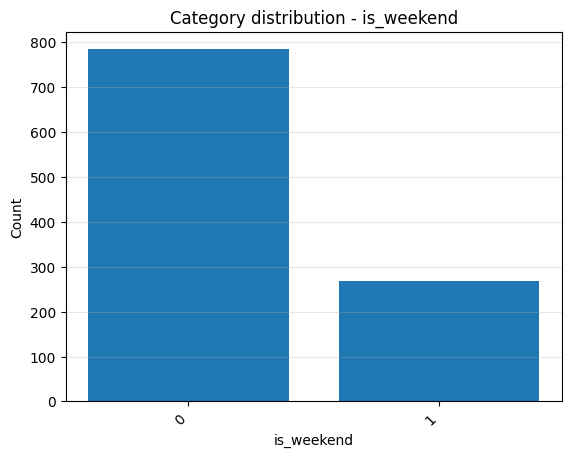

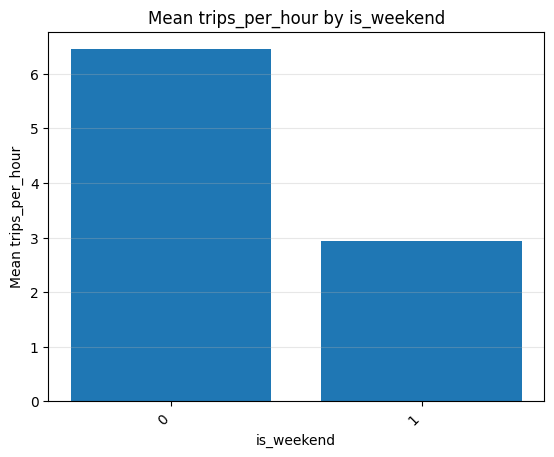

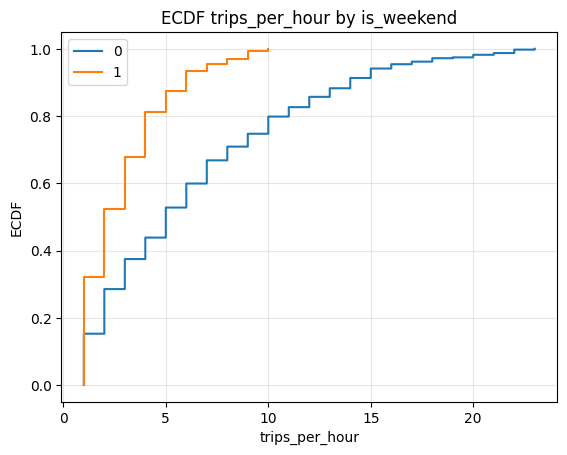

In [132]:
var = "is_weekend"
display(describe_categorical(trips_weather[var], var))
plot_category_distribution(trips_weather, var, f"Category distribution - {var}")
plot_mean_by_category(trips_weather, "trips_per_hour", var, f"Mean trips_per_hour by {var}")
plot_ecdf_by_group(trips_weather, "trips_per_hour", var, f"ECDF trips_per_hour by {var}")


### To merge between Friday & Saturday ?!

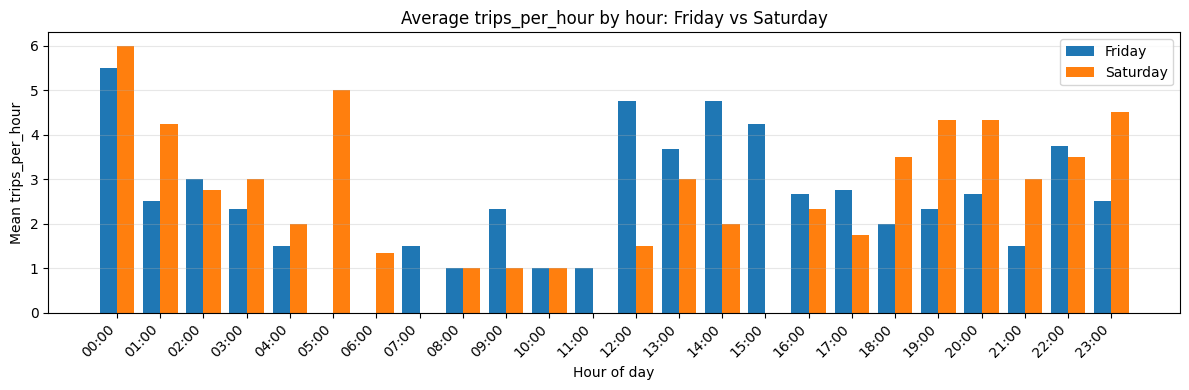

In [133]:
import numpy as np
import matplotlib.pyplot as plt

df_plot = trips_weather.copy()

# Filter only Fri and Sat (שימי לב: אם אצלך זה כתוב אחרת, לשנות כאן)
df_plot = df_plot[df_plot["weekday_name"].isin(["Fri", "Sat"])].copy()

# Mean trips per hour by weekday_name and hour
hourly_mean = (df_plot
               .groupby(["weekday_name", "hour"])["trips_per_hour"]
               .mean()
               .reset_index())

pivot = hourly_mean.pivot(index="hour", columns="weekday_name", values="trips_per_hour")

# Ensure hours 0..23 order and fill missing with 0
pivot = pivot.reindex(range(24), fill_value=0)

# Ensure both columns exist even if one is missing
if "Fri" not in pivot.columns:
    pivot["Fri"] = 0
if "Sat" not in pivot.columns:
    pivot["Sat"] = 0

hours = pivot.index.to_numpy()
hour_labels = [f"{h:02d}:00" for h in hours]

fri = pivot["Fri"].to_numpy()
sat = pivot["Sat"].to_numpy()

# Bar positions
width = 0.4
x = np.arange(len(hours))

plt.figure(figsize=(12, 4))
plt.bar(x - width/2, fri, width=width, label="Friday")
plt.bar(x + width/2, sat, width=width, label="Saturday")

plt.title("Average trips_per_hour by hour: Friday vs Saturday")
plt.xlabel("Hour of day")
plt.ylabel("Mean trips_per_hour")
plt.xticks(x, hour_labels, rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.legend()
plt.tight_layout()
##plt.show()

plt.savefig(r"C:\Users\Aviya\Downloads\Aviya Ohayon-20251203T133736Z-1-001\Aviya Ohayon\Graphs\Fri-Sat_hourly_histogram.png",
            dpi=300, bbox_inches="tight")

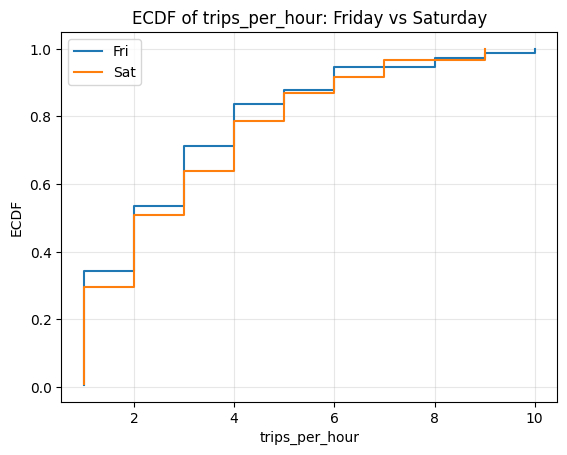

In [136]:
def ecdf(series):
    s = series.dropna().sort_values()
    y = np.arange(1, len(s)+1) / len(s)
    return s, y

plt.figure()

for day in ["Fri", "Sat"]:
    s, y = ecdf(trips_weather.loc[
        trips_weather["weekday_name"] == day, "trips_per_hour"
    ])
    plt.step(s, y, where="post", label=day)

plt.xlabel("trips_per_hour")
plt.ylabel("ECDF")
plt.title("ECDF of trips_per_hour: Friday vs Saturday")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [140]:
quantiles = [0.25, 0.5, 0.75, 0.9, 0.95]

q_wide = (
    trips_weather
    .loc[trips_weather["weekday_name"].isin(["Fri", "Sat"])]
    .groupby("weekday_name")["trips_per_hour"]
    .quantile(quantiles)
    .unstack(level=0)              # columns = Fri/Sat
)

# Rename rows + columns nicely
q_wide.index = ["P25", "P50", "P75", "P90", "P95"]
q_wide = q_wide.rename(columns={"Fri": "Friday", "Sat": "Saturday"})

q_wide


weekday_name,Friday,Saturday
P25,1.0,1.0
P50,2.0,2.0
P75,4.0,4.0
P90,6.0,6.0
P95,7.5,7.0


In [141]:
stats_by_day = (
    trips_weather
    .loc[trips_weather["weekday_name"].isin(["Fri", "Sat"])]
    .groupby("weekday_name")["trips_per_hour"]
    .agg(
        mean="mean",
        std="std",
        IQR=lambda x: x.quantile(0.75) - x.quantile(0.25),
        min="min",
        max="max"
    )
)

# transpose to make rows=metrics, cols=days
stats_wide = stats_by_day.T.rename(columns={"Fri": "Friday", "Sat": "Saturday"})
stats_wide


weekday_name,Friday,Saturday
mean,2.849315,3.049180
std,2.078934,2.076442
IQR,3.000000,3.000000
min,1.000000,1.000000
max,10.000000,9.000000


In [142]:
segment_means = (
    trips_weather
    .loc[trips_weather["weekday_name"].isin(["Fri", "Sat"])]
    .groupby(["weekday_name", "tod_segment"])["trips_per_hour"]
    .mean()
    .unstack(level=0)              # columns = Fri/Sat
)

segment_means = segment_means.rename(columns={"Fri": "Friday", "Sat": "Saturday"})

# Optional: enforce segment order
segment_order = ["Night(0-6)", "Morning(6-12)", "Afternoon(12-18)", "Evening(18-24)"]
segment_means = segment_means.reindex([s for s in segment_order if s in segment_means.index])

segment_means


weekday_name,Friday,Saturday
tod_segment,,
Night(0-6),3.187500,3.421053
Morning(6-12),1.384615,1.166667
Afternoon(12-18),3.863636,2.142857
Evening(18-24),2.454545,3.818182


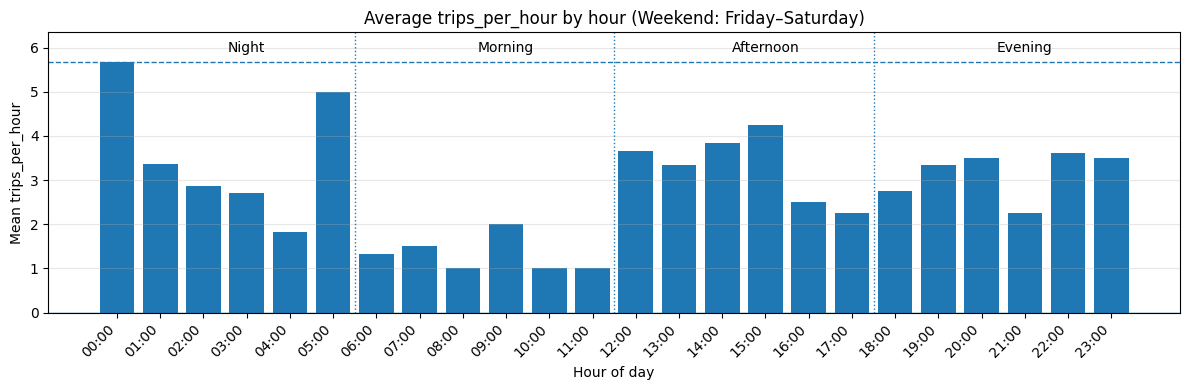

In [134]:
import numpy as np
import matplotlib.pyplot as plt

# Copy working DF
df_plot = trips_weather.copy()

# Keep only Friday and Saturday
df_plot = df_plot[df_plot["weekday_name"].isin(["Fri", "Sat"])].copy()

# Mean trips per hour across Fri–Sat
hourly_mean = (df_plot
               .groupby("hour")["trips_per_hour"]
               .mean()
               .reindex(range(24), fill_value=0))

hours = hourly_mean.index.to_numpy()
hour_labels = [f"{h:02d}:00" for h in hours]

y_max = float(np.nanmax(hourly_mean.values)) if len(hourly_mean) else 0.0

plt.figure(figsize=(12, 4))
plt.bar(hours, hourly_mean.values)

# Baseline at y=0
plt.axhline(0, linewidth=1)

# Horizontal line at max
plt.axhline(y_max, linewidth=1, linestyle="--")

# Time-of-day segments
segments = [
    ("Night", 0, 6),
    ("Morning", 6, 12),
    ("Afternoon", 12, 18),
    ("Evening", 18, 24),
]

for name, start, end in segments:
    # Vertical boundary
    if start not in (0, 24):
        plt.axvline(start - 0.5, linestyle=":", linewidth=1)
    # Label at top
    mid = (start + end) / 2
    plt.text(mid, y_max * 1.03 if y_max > 0 else 0.1,
             name, ha="center", va="bottom")

plt.title("Average trips_per_hour by hour (Weekend: Friday–Saturday)")
plt.xlabel("Hour of day")
plt.ylabel("Mean trips_per_hour")
plt.xticks(hours, hour_labels, rotation=45, ha="right")
plt.ylim(0, y_max * 1.12 if y_max > 0 else 1)
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
##plt.show()

plt.savefig(r"C:\Users\Aviya\Downloads\Aviya Ohayon-20251203T133736Z-1-001\Aviya Ohayon\Graphs\weekdayhourly_histogram.png",
            dpi=300, bbox_inches="tight")



### Does my time segments fit my data? 

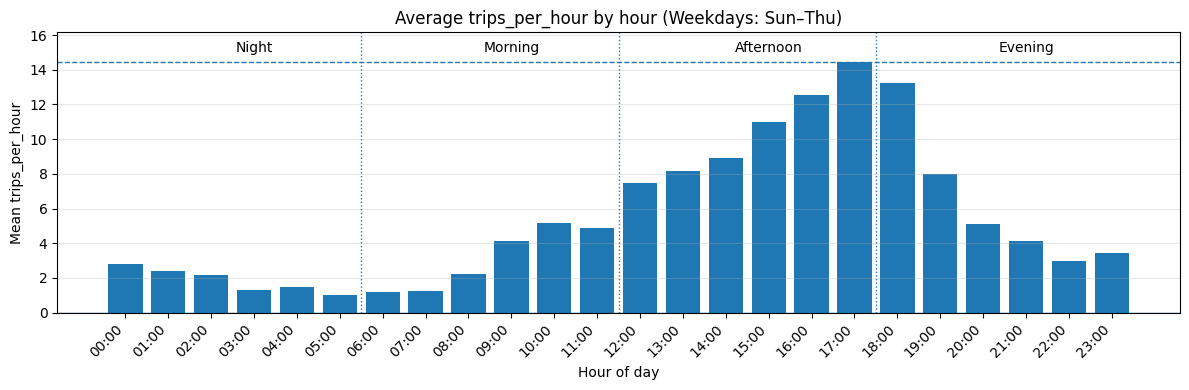

In [135]:
import numpy as np
import matplotlib.pyplot as plt

df_plot = trips_weather.copy()
df_plot = df_plot[df_plot["weekday_name"].isin(["Sun", "Mon", "Tue", "Wed", "Thu"])].copy()

hourly_mean = (df_plot
               .groupby("hour")["trips_per_hour"]
               .mean()
               .reindex(range(24), fill_value=0))

hours = hourly_mean.index.to_numpy()
hour_labels = [f"{h:02d}:00" for h in hours]

y_max = float(np.nanmax(hourly_mean.values)) if len(hourly_mean) else 0.0

plt.figure(figsize=(12, 4))
plt.bar(hours, hourly_mean.values)

# 1) baseline at y=0
plt.axhline(0, linewidth=1)

# 2) horizontal line at max (optional but requested)
plt.axhline(y_max, linewidth=1, linestyle="--")

# Time-of-day segments (as defined earlier)
segments = [
    ("Night", 0, 6),
    ("Morning", 6, 12),
    ("Afternoon", 12, 18),
    ("Evening", 18, 24),
]

# Vertical boundaries + labels near the top
for name, start, end in segments:
    # boundary lines (skip 0 and 24 for cleanliness if you want)
    if start not in (0, 24):
        plt.axvline(start - 0.5, linestyle=":", linewidth=1)
    # label centered in the segment
    mid = (start + end) / 2
    plt.text(mid, y_max * 1.03 if y_max > 0 else 0.1, name, ha="center", va="bottom")

plt.title("Average trips_per_hour by hour (Weekdays: Sun–Thu)")
plt.xlabel("Hour of day")
plt.ylabel("Mean trips_per_hour")
plt.xticks(hours, hour_labels, rotation=45, ha="right")
plt.ylim(0, y_max * 1.12 if y_max > 0 else 1)
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
##plt.show()

plt.savefig(r"C:\Users\Aviya\Downloads\Aviya Ohayon-20251203T133736Z-1-001\Aviya Ohayon\Graphs\weekend_hourly_histogram.png",
            dpi=300, bbox_inches="tight")
